In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pygad
import wandb
import keras.backend as K
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

tf.random.set_seed(0)
np.random.seed(0)

import matplotlib.pyplot as plt
import scipy.io as sio

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2847397205159842263
xla_global_id: -1
]


2023-08-23 15:12:10.431047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-23 15:12:10.431171: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
num_samples = 10000
num_dimensions = 30

# Generate random samples
raw_data = np.random.rand(num_samples, num_dimensions)

outlier_indices_1 = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
outlyin_amount_1 = 20
outlier_indices_2 = [0,2,4,6,8,10,12]
outlyin_amount_2 = 10
outlier_indices_3 = [0,3,6,9,12,15,18]
outlyin_amount_3 = 5
outlier_indices_4 = [0,4,8,12,16,20,24]
outlyin_amount_4 = 2
outlier_indices_5 = [0,5,10,15,20,25,29]
outlyin_amount_5 = 1.1
outlier_indices_6 = [0,1,2,3,4,5,6]
outlyin_amount_6 = [20,15,10,5,2,1.1,1.05]

corrupted_data = raw_data

corrupted_data[100:120, outlier_indices_1] = outlyin_amount_1
corrupted_data[200:220, outlier_indices_2] = outlyin_amount_2
corrupted_data[300:320, outlier_indices_3] = outlyin_amount_3
corrupted_data[400:420, outlier_indices_4] = outlyin_amount_4
corrupted_data[500:520, outlier_indices_5] = outlyin_amount_5
corrupted_data[600:620, outlier_indices_6] = outlyin_amount_6

for outlier_gene_index in range(corrupted_data.shape[1]+1):
    corrupted_data[700+outlier_gene_index,:outlier_gene_index] = outlyin_amount_1
    

# print(raw_data)

# Training the RAE

In [4]:
latent_dim = 5

encoder_inputs = keras.Input(shape=(num_dimensions,))
# x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
# x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(encoder_inputs)
x = layers.Dense(8, activation="relu")(x)
x = layers.Dense(5, activation="relu")(x)
encoder_output = layers.Dense(latent_dim, activation="relu")(x)
# z_mean = layers.Dense(latent_dim, name="z_mean")(x)
# z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
# z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, encoder_output, name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
# x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# x = layers.Reshape((7, 7, 64))(x)
# x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
x = layers.Dense(5, activation="relu")(latent_inputs)
x = layers.Dense(8, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
# x = layers.Dense(512, activation="relu")(x)
decoder_outputs = layers.Dense(num_dimensions, activation="tanh")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")



class RAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.z_tracker = keras.metrics.Mean(name="z_loss")
        self.REG_tracker = keras.metrics.Mean(name="REG_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.z_tracker,
            self.REG_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape(persistent=True) as tape:
            z = self.encoder(data)
            reconstruction = self.decoder(z)
#             reconstruction_loss = tf.reduce_mean(
#                 tf.reduce_sum(
#                     keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
#                 )
#             )
            reconstruction_loss = tf.keras.losses.MeanSquaredError()(data,reconstruction)
#             reconstruction_loss = tf.keras.losses.BinaryCrossentropy()(data, reconstruction)
#             
            z_loss = K.mean(K.square(z), axis=[1])
    

#             gradients = tape.gradient(reconstruction, self.encoder(data))
    

#             gradient_norm = 0.0
#             for gradient in gradients:
#                 if gradient is not None:
#                     gradient_norm += tf.norm(gradient, ord=2)
    

            REG_loss = K.mean(K.square(K.gradients(K.square(reconstruction), z)))

            total_loss = reconstruction_loss +  0.01 * z_loss + 0.01 * REG_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.z_tracker.update_state(z_loss)
        self.REG_tracker.update_state(REG_loss)
        del tape
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "z_loss": self.z_tracker.result(),
            "REG_loss": self.REG_tracker.result(),
        }
        

# mnist_data = mat_data['X']
tdata = np.concatenate([corrupted_data], axis=0)
tdata = np.expand_dims(tdata, -1).astype("float32")

rae = RAE(encoder, decoder)
rae.compile(optimizer=tf.keras.optimizers.legacy.Adam())
history = rae.fit(tdata, epochs=100, batch_size=1024)

Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 1.4578 - reconstruction_loss: 1.6113 - z_loss: 0.0038 - REG_loss: 0.0011
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 1.5720 - reconstruction_loss: 1.5800 - z_loss: 0.0111 - REG_loss: 0.0083
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 1.6355 - reconstruction_loss: 1.5458 - z_loss: 0.0313 - REG_loss: 0.0398
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 1.6409 - reconstruction_loss: 1.5174 - z_loss: 0.0837 - REG_loss: 0.1777
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 1.4173 - reconstruction_loss: 1.4654 - z_loss: 0.2031 - REG_loss: 0.6374
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 1.3535 - reconstruction_loss: 1.3562 - z_loss: 0.4145 - REG_loss: 1.6826
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 1.2962 - reconstruction_loss: 1.3183 - z_loss: 0.73

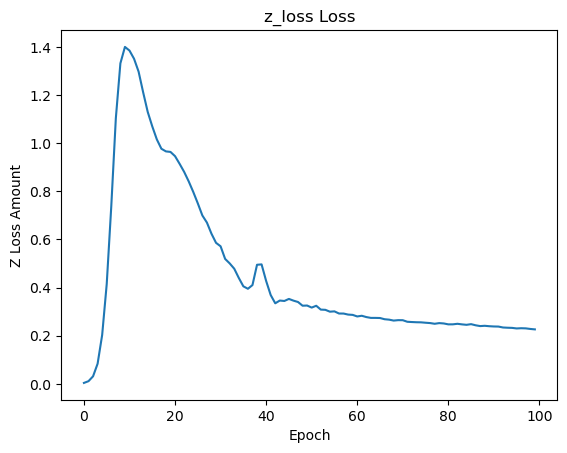

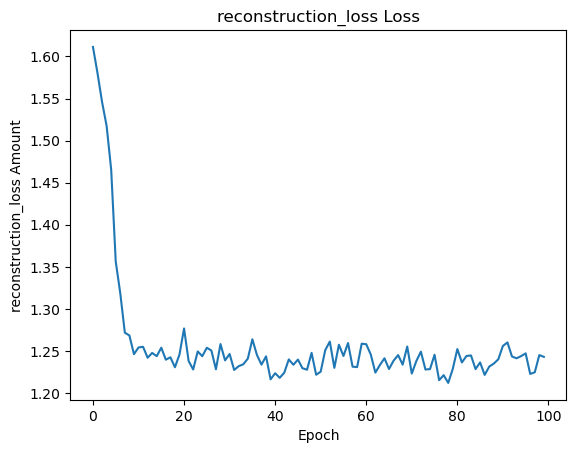

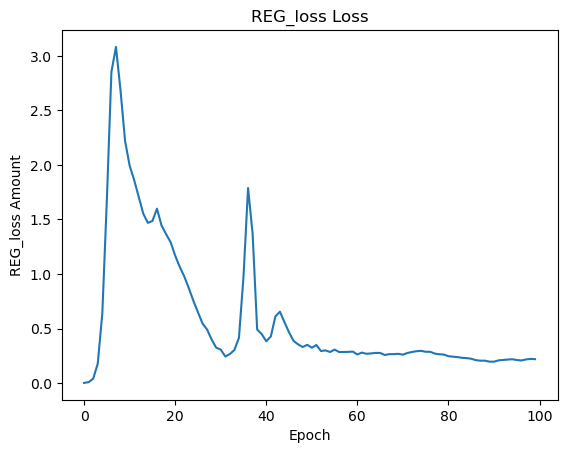

In [7]:
plt.plot(history.history['z_loss'])
plt.title('z_loss Loss')
plt.xlabel('Epoch')
plt.ylabel('Z Loss Amount')
plt.show()

plt.plot(history.history['reconstruction_loss'])
plt.title('reconstruction_loss Loss')
plt.xlabel('Epoch')
plt.ylabel('reconstruction_loss Amount')
plt.show()

plt.plot(history.history['REG_loss'])
plt.title('REG_loss Loss')
plt.xlabel('Epoch')
plt.ylabel('REG_loss Amount')
plt.show()

In [8]:
out_1 = corrupted_data[100:120, :] 
out_2 = corrupted_data[200:220, :] 
out_3 = corrupted_data[300:320, :] 
out_4 = corrupted_data[400:420, :]
out_5 = corrupted_data[500:520, :] 
# out_6 = corrupted_data[600:620, :]
# out_7 = corrupted_data[700:730, :]
 
# all_outlier = np.concatenate((out_1, out_2, out_3, out_4, out_5, out_6, out_7), axis=0)
# all_outlier = np.concatenate((out_1, out_2), axis=0)

out_rec = []

for i in range(out_1.shape[0]):
    
    outlier1 = out_1[i,:].reshape([1,num_dimensions])

    z = rae.encoder(outlier1)
    reconstruction = rae.decoder(z)

    reconstruction_loss = tf.keras.losses.MeanSquaredError()(outlier1,reconstruction)
    out_rec.append(reconstruction_loss.numpy())

out_mean = np.mean(np.array(out_rec))
out_std = np.std(np.array(out_rec))

print("Mean = ", out_mean)
print("Std = ", out_std)

Mean =  252.92
Std =  0.023237891


In [10]:
inliers = corrupted_data[5:80,:]
mean_data = np.mean(corrupted_data, axis=0)
outlier1 = corrupted_data[101,:]

mean_mean = []

for step in range(10):

    mean_ins_error = []

    for index in range(inliers.shape[0]):

        cand = inliers[index,:]

        cand = cand.reshape([1,num_dimensions])

        mean_data = mean_data.reshape([1,num_dimensions])

        z = rae.encoder(cand)
        reconstruction = rae.decoder(z)

        reconstruction_loss = tf.keras.losses.MeanSquaredError()(cand,reconstruction)

        mean_ins_error.append(reconstruction_loss.numpy())

    #     print("MEAN", index, " = ", reconstruction_loss.numpy())

    mean_ins_error = np.array(mean_ins_error)
    print("mean = ", np.mean(mean_ins_error))
    
    mean_mean.append(np.mean(mean_ins_error))
    

print("MEAN_MEAN = ", np.mean(np.array(mean_mean)))
print("std_MEAN = ", np.std(np.array(mean_mean)))

mean =  0.084217876
mean =  0.084217876
mean =  0.084217876
mean =  0.084217876
mean =  0.084217876
mean =  0.084217876
mean =  0.084217876
mean =  0.084217876
mean =  0.084217876
mean =  0.084217876
MEAN_MEAN =  0.08421788
std_MEAN =  7.450581e-09


# Genetic Part

In [19]:
best_solutions = []

wandb.init(
    # set the wandb project where this run will be logged
    project="RAE_Outlier_GA_Dual_Test_1",
    
    # track hyperparameters and run metadata
#     config={
#     "learning_rate": 0.02,
#     "architecture": "CNN",
#     "dataset": "CIFAR-100",
#     "epochs": 20,
#     }
)

for out_indexing in range(1,corrupted_data.shape[1]+1):
    
    def fit_test(ga_instance, solution, solution_idx): 

        inliers = corrupted_data[10:13,:]

        avg_ins = np.mean(inliers, axis=0)
        avg_ins = avg_ins.reshape([1,30])

        particle = corrupted_data[700+out_indexing,:]
        particle = particle.reshape([1,30])

    #     abn_subspace = solution * val_features[6728,:]

    #     abn_subspace = abn_subspace.reshape([1,30])

        avg_in_rec = []

        for index in range(inliers.shape[0]):

            candidate_inlier = inliers[index,:]
            candidate_inlier = candidate_inlier.reshape([1,30])

            in_normal_subspace = solution
            in_bad_subspace = 1 - solution        

            in_remain = candidate_inlier * in_normal_subspace



            in_replace = in_bad_subspace * avg_ins

            in_candidate = in_remain + in_replace

            z = rae.encoder(in_candidate)
            in_candidate_rec = rae.decoder(z)


            rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)

            avg_in_rec.append(rec_loss.numpy())

        avg_in_rec = np.array(avg_in_rec)
        avg_in_rec = np.mean(avg_in_rec)





    #     z_mean, z_log_var, z = vae.encoder(particle)
    #     reconstruction_1 = vae.decoder(z)

        out_normal_subspace = solution
        out_bad_subspace = 1 - solution

        out_remain = particle * out_normal_subspace



        out_replace = avg_ins * out_bad_subspace

        out_candidate = out_remain + out_replace


        z = rae.encoder(out_candidate)
        out_candidate_rec = rae.decoder(z)

        rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
        rec_loss = rec_loss.numpy()

        fitness = avg_in_rec / rec_loss

        return -fitness



#     def fitness_func_avg(ga_instance, solution, solution_idx):

#         fit_mean = []

#         for i in range(10):
#             fit_mean.append(fit_test(solution))

#         return np.mean(np.array(fit_mean))

    def on_generation(ga):
        print("Generation", ga.generations_completed)

        solution, solution_fitness, solution_idx = ga_instance.best_solution()
        
        wandb.log({"GA - " + str(out_indexing) + "/solution_fitness": solution_fitness})

        print(solution_fitness)


    fitness_function = fit_test

    num_generations = 200
    num_parents_mating = 2

    sol_per_pop = 100
    num_genes = corrupted_data.shape[1]

    init_range_low = -2
    init_range_high = 5

    parent_selection_type = "sss"
    keep_parents = 1

    space = [[0,1] for i in range(num_genes)]

    crossover_type = "single_point"

    mutation_type = "random"
    mutation_percent_genes = 2

    ga_instance = pygad.GA(num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_function,
                           sol_per_pop=sol_per_pop,
                           num_genes=num_genes,
                           init_range_low=init_range_low,
                           init_range_high=init_range_high,
                           parent_selection_type=parent_selection_type,
                           keep_parents=keep_parents,
#                            keep_elitism=2,
                           crossover_type=crossover_type,
                           mutation_type=mutation_type,
                           mutation_percent_genes=mutation_percent_genes,
                           on_generation=on_generation,
                           gene_space = space)

    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print("##########  End of the ", out_indexing, " epoch ##########")
    print("Parameters of the best solution : {solution}".format(solution=solution))

    best_solutions.append(solution)
    
    sample = corrupted_data[700+out_indexing,:]
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for gene_no in range(30):
        
        if ((sample[gene_no] == 20) and (solution[gene_no] == 1)):
            
            TP = TP + 1
        
        elif (sample[gene_no] != 20) and (solution[gene_no] == 1):
            
            FP = FP + 1
            
        elif (sample[gene_no] != 20) and (solution[gene_no] == 0):
            
            TN = TN + 1
            
        elif (sample[gene_no] == 20) and (solution[gene_no] == 0):
            
            FN = FN + 1
    
    precision = TP / (TP + FP)

    recall = TP / (TP + FN)

    F1 = 2 * (precision * recall)/(precision + recall)
    
    MCC = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    
    wandb.log({"Metrics/precision": precision, 
               "Metrics/recall": recall,
               "Metrics/F1": F1,
               "Metrics/MCC": MCC,
               "Metrics/num": out_indexing})
    
best_solutions = np.array(best_solutions)
np.save('best_solutions.npy', best_solutions)

GA - 1/solution_fitness,▁▄██████████████████████████████████████
GA - 10/solution_fitness,▁▇██████████████████████████████████████
GA - 11/solution_fitness,▁▅██████████████████████████████████████
GA - 12/solution_fitness,▁▄██████████████████████████████████████
GA - 13/solution_fitness,▁▆▇█████████████████████████████████████
GA - 14/solution_fitness,▁▅██████████████████████████████████████
GA - 15/solution_fitness,▁▆██████████████████████████████████████
GA - 16/solution_fitness,▁▅██████████████████████████████████████
GA - 17/solution_fitness,▁▇██████████████████████████████████████
GA - 18/solution_fitness,▁▆▇▇▇▇▇▇▇███████████████████████████████
GA - 19/solution_fitness,▁▇██████████████████████████████████████


/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/pygad/pygad.py:641: UserWarning: The percentage of genes to mutate (mutation_percent_genes=2) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  if not self.suppress_warnings: warnings.warn("The percentage of genes to mutate (mutation_percent_genes={mutation_percent}) resutled in selecting ({mutation_num}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.".format(mutation_percent=mutation_percent_genes, mutation_num=mutation_num_genes))


Generation 1
-0.003128832
Generation 2
-0.0029370966
Generation 3
-0.0026565772
Generation 4
-0.0025778618
Generation 5
-0.0025608696
Generation 6
-0.0025608696
Generation 7
-0.0025608696
Generation 8
-0.0025608696
Generation 9
-0.0025608696
Generation 10
-0.0025608696
Generation 11
-0.0025608696
Generation 12
-0.0025608696
Generation 13
-0.0025608696
Generation 14
-0.0025608696
Generation 15
-0.0025608696
Generation 16
-0.0025608696
Generation 17
-0.0025608696
Generation 18
-0.0025608696
Generation 19
-0.0025608696
Generation 20
-0.0025608696
Generation 21
-0.0025608696
Generation 22
-0.0025608696
Generation 23
-0.0025608696
Generation 24
-0.0025608696
Generation 25
-0.0025608696
Generation 26
-0.0025608696
Generation 27
-0.0025608696
Generation 28
-0.0025608696
Generation 29
-0.0025608696
Generation 30
-0.0025608696
Generation 31
-0.0025608696
Generation 32
-0.0025608696
Generation 33
-0.0025608696
Generation 34
-0.0025608696
Generation 35
-0.0025608696
Generation 36
-0.0025608696
Ge

Generation 85
-0.0012936812
Generation 86
-0.0012936812
Generation 87
-0.0012936812
Generation 88
-0.0012936812
Generation 89
-0.0012936812
Generation 90
-0.0012936812
Generation 91
-0.0012936812
Generation 92
-0.0012936812
Generation 93
-0.0012936812
Generation 94
-0.0012936812
Generation 95
-0.0012936812
Generation 96
-0.0012936812
Generation 97
-0.0012936812
Generation 98
-0.0012936812
Generation 99
-0.0012936812
Generation 100
-0.0012936812
Generation 101
-0.0012936812
Generation 102
-0.0012936812
Generation 103
-0.0012936812
Generation 104
-0.0012936812
Generation 105
-0.0012936812
Generation 106
-0.0012936812
Generation 107
-0.0012936812
Generation 108
-0.0012936812
Generation 109
-0.0012936812
Generation 110
-0.0012936812
Generation 111
-0.0012936812
Generation 112
-0.0012936812
Generation 113
-0.0012936812
Generation 114
-0.0012936812
Generation 115
-0.0012936812
Generation 116
-0.0012936812
Generation 117
-0.0012936812
Generation 118
-0.0012936812
Generation 119
-0.0012936812


Generation 161
-0.00090074475
Generation 162
-0.00090074475
Generation 163
-0.00090074475
Generation 164
-0.00090074475
Generation 165
-0.00090074475
Generation 166
-0.00090074475
Generation 167
-0.00090074475
Generation 168
-0.00090074475
Generation 169
-0.00090074475
Generation 170
-0.00090074475
Generation 171
-0.00090074475
Generation 172
-0.00090074475
Generation 173
-0.00090074475
Generation 174
-0.00090074475
Generation 175
-0.00090074475
Generation 176
-0.00090074475
Generation 177
-0.00090074475
Generation 178
-0.00090074475
Generation 179
-0.00090074475
Generation 180
-0.00090074475
Generation 181
-0.00090074475
Generation 182
-0.00090074475
Generation 183
-0.00090074475
Generation 184
-0.00090074475
Generation 185
-0.00090074475
Generation 186
-0.00090074475
Generation 187
-0.00090074475
Generation 188
-0.00090074475
Generation 189
-0.00090074475
Generation 190
-0.00090074475
Generation 191
-0.00090074475
Generation 192
-0.00090074475
Generation 193
-0.00090074475
Generation

Generation 30
-0.00060278
Generation 31
-0.00060278
Generation 32
-0.00060278
Generation 33
-0.00060278
Generation 34
-0.00060278
Generation 35
-0.00060278
Generation 36
-0.00060278
Generation 37
-0.00060278
Generation 38
-0.00060278
Generation 39
-0.00060278
Generation 40
-0.00060278
Generation 41
-0.00060278
Generation 42
-0.00060278
Generation 43
-0.00060278
Generation 44
-0.00060278
Generation 45
-0.00060278
Generation 46
-0.00060278
Generation 47
-0.00060278
Generation 48
-0.00060278
Generation 49
-0.00060278
Generation 50
-0.00060278
Generation 51
-0.00060278
Generation 52
-0.00060278
Generation 53
-0.00060278
Generation 54
-0.00060278
Generation 55
-0.00060278
Generation 56
-0.00060278
Generation 57
-0.00060278
Generation 58
-0.00060278
Generation 59
-0.00060278
Generation 60
-0.00060278
Generation 61
-0.00060278
Generation 62
-0.00060278
Generation 63
-0.00060278
Generation 64
-0.00060278
Generation 65
-0.00060278
Generation 66
-0.00060278
Generation 67
-0.00060278
Generation 6

-0.0005234284
Generation 125
-0.0005234284
Generation 126
-0.0005234284
Generation 127
-0.0005234284
Generation 128
-0.0005234284
Generation 129
-0.0005234284
Generation 130
-0.0005234284
Generation 131
-0.0005234284
Generation 132
-0.0005234284
Generation 133
-0.0005234284
Generation 134
-0.0005234284
Generation 135
-0.0005234284
Generation 136
-0.0005234284
Generation 137
-0.0005234284
Generation 138
-0.0005234284
Generation 139
-0.0005234284
Generation 140
-0.0005234284
Generation 141
-0.0005234284
Generation 142
-0.0005234284
Generation 143
-0.0005234284
Generation 144
-0.0005234284
Generation 145
-0.0005234284
Generation 146
-0.0005234284
Generation 147
-0.0005234284
Generation 148
-0.0005234284
Generation 149
-0.0005234284
Generation 150
-0.0005234284
Generation 151
-0.0005234284
Generation 152
-0.0005234284
Generation 153
-0.0005234284
Generation 154
-0.0005234284
Generation 155
-0.0005234284
Generation 156
-0.0005234284
Generation 157
-0.0005234284
Generation 158
-0.0005234284


-0.00047474532
Generation 199
-0.00047474532
Generation 200
-0.00047474532
##########  End of the  7  epoch ##########
Parameters of the best solution : [1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Generation 1
-0.00051387685
Generation 2
-0.00046689558
Generation 3
-0.00044282465
Generation 4
-0.00043296974
Generation 5
-0.0004228938
Generation 6
-0.0004228938
Generation 7
-0.0004228938
Generation 8
-0.0004228938
Generation 9
-0.0004228938
Generation 10
-0.0004228938
Generation 11
-0.0004228938
Generation 12
-0.0004228938
Generation 13
-0.0004228938
Generation 14
-0.0004228938
Generation 15
-0.0004228938
Generation 16
-0.0004228938
Generation 17
-0.0004228938
Generation 18
-0.0004228938
Generation 19
-0.0004228938
Generation 20
-0.0004228938
Generation 21
-0.0004228938
Generation 22
-0.0004228938
Generation 23
-0.0004228938
Generation 24
-0.0004228938
Generation 25
-0.0004228938
Generation 26
-0.0004228938
Generation 27
-0.0004228938
Gen

-0.00038079085
Generation 74
-0.00038079085
Generation 75
-0.00038079085
Generation 76
-0.00038079085
Generation 77
-0.00038079085
Generation 78
-0.00038079085
Generation 79
-0.00038079085
Generation 80
-0.00038079085
Generation 81
-0.00038079085
Generation 82
-0.00038079085
Generation 83
-0.00038079085
Generation 84
-0.00038079085
Generation 85
-0.00038079085
Generation 86
-0.00038079085
Generation 87
-0.00038079085
Generation 88
-0.00038079085
Generation 89
-0.00038079085
Generation 90
-0.00038079085
Generation 91
-0.00038079085
Generation 92
-0.00038079085
Generation 93
-0.00038079085
Generation 94
-0.00038079085
Generation 95
-0.00038079085
Generation 96
-0.00038079085
Generation 97
-0.00038079085
Generation 98
-0.00038079085
Generation 99
-0.00038079085
Generation 100
-0.00038079085
Generation 101
-0.00038079085
Generation 102
-0.00038079085
Generation 103
-0.00038079085
Generation 104
-0.00038079085
Generation 105
-0.00038079085
Generation 106
-0.00038079085
Generation 107
-0.000

-0.00036483232
Generation 146
-0.00036483232
Generation 147
-0.00036483232
Generation 148
-0.00036483232
Generation 149
-0.00036483232
Generation 150
-0.00036483232
Generation 151
-0.00036483232
Generation 152
-0.00036483232
Generation 153
-0.00036483232
Generation 154
-0.00036483232
Generation 155
-0.00036483232
Generation 156
-0.00036483232
Generation 157
-0.00036483232
Generation 158
-0.00036483232
Generation 159
-0.00036483232
Generation 160
-0.00036483232
Generation 161
-0.00036483232
Generation 162
-0.00036483232
Generation 163
-0.00036483232
Generation 164
-0.00036483232
Generation 165
-0.00036483232
Generation 166
-0.00036483232
Generation 167
-0.00036483232
Generation 168
-0.00036483232
Generation 169
-0.00036483232
Generation 170
-0.00036483232
Generation 171
-0.00036483232
Generation 172
-0.00036483232
Generation 173
-0.00036483232
Generation 174
-0.00036483232
Generation 175
-0.00036483232
Generation 176
-0.00036483232
Generation 177
-0.00036483232
Generation 178
-0.0003648

Generation 12
-0.00031112492
Generation 13
-0.00031112492
Generation 14
-0.00031112492
Generation 15
-0.00031112492
Generation 16
-0.00031112492
Generation 17
-0.00031112492
Generation 18
-0.00031112492
Generation 19
-0.00031112492
Generation 20
-0.00031112492
Generation 21
-0.00031112492
Generation 22
-0.00031112492
Generation 23
-0.00031112492
Generation 24
-0.00031112492
Generation 25
-0.00031112492
Generation 26
-0.00031112492
Generation 27
-0.00031112492
Generation 28
-0.00031112492
Generation 29
-0.00031112492
Generation 30
-0.00031112492
Generation 31
-0.00031112492
Generation 32
-0.00031112492
Generation 33
-0.00031112492
Generation 34
-0.00031112492
Generation 35
-0.00031112492
Generation 36
-0.00031112492
Generation 37
-0.00031112492
Generation 38
-0.00031112492
Generation 39
-0.00031112492
Generation 40
-0.00031112492
Generation 41
-0.00031112492
Generation 42
-0.00031112492
Generation 43
-0.00031112492
Generation 44
-0.00031112492
Generation 45
-0.00031112492
Generation 46


Generation 86
-0.00030059463
Generation 87
-0.00030059463
Generation 88
-0.00030059463
Generation 89
-0.00030059463
Generation 90
-0.00030059463
Generation 91
-0.00030059463
Generation 92
-0.00030059463
Generation 93
-0.00030059463
Generation 94
-0.00030059463
Generation 95
-0.00030059463
Generation 96
-0.00030059463
Generation 97
-0.00030059463
Generation 98
-0.00030059463
Generation 99
-0.00030059463
Generation 100
-0.00030059463
Generation 101
-0.00030059463
Generation 102
-0.00030059463
Generation 103
-0.00030059463
Generation 104
-0.00030059463
Generation 105
-0.00030059463
Generation 106
-0.00030059463
Generation 107
-0.00030059463
Generation 108
-0.00030059463
Generation 109
-0.00030059463
Generation 110
-0.00030059463
Generation 111
-0.00030059463
Generation 112
-0.00030059463
Generation 113
-0.00030059463
Generation 114
-0.00030059463
Generation 115
-0.00030059463
Generation 116
-0.00030059463
Generation 117
-0.00030059463
Generation 118
-0.00030059463
Generation 119
-0.000300

-0.00029317098
Generation 158
-0.00029317098
Generation 159
-0.00029317098
Generation 160
-0.00029317098
Generation 161
-0.00029317098
Generation 162
-0.00029317098
Generation 163
-0.00029317098
Generation 164
-0.00029317098
Generation 165
-0.00029317098
Generation 166
-0.00029317098
Generation 167
-0.00029317098
Generation 168
-0.00029317098
Generation 169
-0.00029317098
Generation 170
-0.00029317098
Generation 171
-0.00029317098
Generation 172
-0.00029317098
Generation 173
-0.00029317098
Generation 174
-0.00029317098
Generation 175
-0.00029317098
Generation 176
-0.00029317098
Generation 177
-0.00029317098
Generation 178
-0.00029317098
Generation 179
-0.00029317098
Generation 180
-0.00029317098
Generation 181
-0.00029317098
Generation 182
-0.00029317098
Generation 183
-0.00029317098
Generation 184
-0.00029317098
Generation 185
-0.00029317098
Generation 186
-0.00029317098
Generation 187
-0.00029317098
Generation 188
-0.00029317098
Generation 189
-0.00029317098
Generation 190
-0.0002931

Generation 24
-0.00026756336
Generation 25
-0.00026756336
Generation 26
-0.00026756336
Generation 27
-0.00026756336
Generation 28
-0.00026756336
Generation 29
-0.00026756336
Generation 30
-0.00026756336
Generation 31
-0.00026756336
Generation 32
-0.00026756336
Generation 33
-0.00026756336
Generation 34
-0.00026756336
Generation 35
-0.00026756336
Generation 36
-0.00026756336
Generation 37
-0.00026756336
Generation 38
-0.00026756336
Generation 39
-0.00026756336
Generation 40
-0.00026756336
Generation 41
-0.00026756336
Generation 42
-0.00026756336
Generation 43
-0.00026756336
Generation 44
-0.00026756336
Generation 45
-0.00026756336
Generation 46
-0.00026756336
Generation 47
-0.00026756336
Generation 48
-0.00026756336
Generation 49
-0.00026756336
Generation 50
-0.00026756336
Generation 51
-0.00026756336
Generation 52
-0.00026756336
Generation 53
-0.00026756336
Generation 54
-0.00026756336
Generation 55
-0.00026756336
Generation 56
-0.00026756336
Generation 57
-0.00026756336
Generation 58


-0.00025429123
Generation 98
-0.00025429123
Generation 99
-0.00025429123
Generation 100
-0.00025429123
Generation 101
-0.00025429123
Generation 102
-0.00025429123
Generation 103
-0.00025429123
Generation 104
-0.00025429123
Generation 105
-0.00025429123
Generation 106
-0.00025429123
Generation 107
-0.00025429123
Generation 108
-0.00025429123
Generation 109
-0.00025429123
Generation 110
-0.00025429123
Generation 111
-0.00025429123
Generation 112
-0.00025429123
Generation 113
-0.00025429123
Generation 114
-0.00025429123
Generation 115
-0.00025429123
Generation 116
-0.00025429123
Generation 117
-0.00025429123
Generation 118
-0.00025429123
Generation 119
-0.00025429123
Generation 120
-0.00025429123
Generation 121
-0.00025429123
Generation 122
-0.00025429123
Generation 123
-0.00025429123
Generation 124
-0.00025429123
Generation 125
-0.00025429123
Generation 126
-0.00025429123
Generation 127
-0.00025429123
Generation 128
-0.00025429123
Generation 129
-0.00025429123
Generation 130
-0.000254291

Generation 169
-0.00024949654
Generation 170
-0.00024949654
Generation 171
-0.00024949654
Generation 172
-0.00024949654
Generation 173
-0.00024949654
Generation 174
-0.00024949654
Generation 175
-0.00024949654
Generation 176
-0.00024949654
Generation 177
-0.00024949654
Generation 178
-0.00024949654
Generation 179
-0.00024949654
Generation 180
-0.00024949654
Generation 181
-0.00024949654
Generation 182
-0.00024949654
Generation 183
-0.00024949654
Generation 184
-0.00024949654
Generation 185
-0.00024949654
Generation 186
-0.00024949654
Generation 187
-0.00024949654
Generation 188
-0.00024949654
Generation 189
-0.00024949654
Generation 190
-0.00024949654
Generation 191
-0.00024949654
Generation 192
-0.00024949654
Generation 193
-0.00024949654
Generation 194
-0.00024949654
Generation 195
-0.00024949654
Generation 196
-0.00024949654
Generation 197
-0.00024949654
Generation 198
-0.00024949654
Generation 199
-0.00024949654
Generation 200
-0.00024949654
##########  End of the  18  epoch ######

Generation 36
-0.00022907711
Generation 37
-0.00022907711
Generation 38
-0.00022907711
Generation 39
-0.00022907711
Generation 40
-0.00022907711
Generation 41
-0.00022907711
Generation 42
-0.00022907711
Generation 43
-0.00022907711
Generation 44
-0.00022907711
Generation 45
-0.00022907711
Generation 46
-0.00022907711
Generation 47
-0.00022907711
Generation 48
-0.00022907711
Generation 49
-0.00022907711
Generation 50
-0.00022907711
Generation 51
-0.00022907711
Generation 52
-0.00022907711
Generation 53
-0.00022907711
Generation 54
-0.00022907711
Generation 55
-0.00022907711
Generation 56
-0.00022907711
Generation 57
-0.00022907711
Generation 58
-0.00022907711
Generation 59
-0.00022907711
Generation 60
-0.00022907711
Generation 61
-0.00022907711
Generation 62
-0.00022907711
Generation 63
-0.00022907711
Generation 64
-0.00022907711
Generation 65
-0.00022907711
Generation 66
-0.00022907711
Generation 67
-0.00022907711
Generation 68
-0.00022907711
Generation 69
-0.00022907711
Generation 70


-0.00022907711
Generation 110
-0.00022907711
Generation 111
-0.00022907711
Generation 112
-0.00022907711
Generation 113
-0.00022907711
Generation 114
-0.00022907711
Generation 115
-0.00022907711
Generation 116
-0.00022907711
Generation 117
-0.00022907711
Generation 118
-0.00022907711
Generation 119
-0.00022907711
Generation 120
-0.00022907711
Generation 121
-0.00022907711
Generation 122
-0.00022907711
Generation 123
-0.00022907711
Generation 124
-0.00022907711
Generation 125
-0.00022907711
Generation 126
-0.00022907711
Generation 127
-0.00022907711
Generation 128
-0.00022907711
Generation 129
-0.00022907711
Generation 130
-0.00022907711
Generation 131
-0.00022907711
Generation 132
-0.00022907711
Generation 133
-0.00022907711
Generation 134
-0.00022907711
Generation 135
-0.00022907711
Generation 136
-0.00022907711
Generation 137
-0.00022907711
Generation 138
-0.00022907711
Generation 139
-0.00022907711
Generation 140
-0.00022907711
Generation 141
-0.00022907711
Generation 142
-0.0002290

-0.0002197763
Generation 187
-0.0002197763
Generation 188
-0.0002197763
Generation 189
-0.0002197763
Generation 190
-0.0002197763
Generation 191
-0.0002197763
Generation 192
-0.0002197763
Generation 193
-0.0002197763
Generation 194
-0.0002197763
Generation 195
-0.0002197763
Generation 196
-0.0002197763
Generation 197
-0.0002197763
Generation 198
-0.0002197763
Generation 199
-0.0002197763
Generation 200
-0.0002197763
##########  End of the  22  epoch ##########
Parameters of the best solution : [0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0.]
Generation 1
-0.00023680038
Generation 2
-0.00022862235
Generation 3
-0.00022484409
Generation 4
-0.00022269785
Generation 5
-0.00022110199
Generation 6
-0.00022110199
Generation 7
-0.00022110199
Generation 8
-0.00022110199
Generation 9
-0.00022110199
Generation 10
-0.00022110199
Generation 11
-0.00022110199
Generation 12
-0.00022110199
Generation 13
-0.00022110199
Generation 14
-0.00022110199
Generation 

-0.00021470439
Generation 55
-0.00021470439
Generation 56
-0.00021470439
Generation 57
-0.00021470439
Generation 58
-0.00021470439
Generation 59
-0.00021470439
Generation 60
-0.00021470439
Generation 61
-0.00021470439
Generation 62
-0.00021470439
Generation 63
-0.00021170572
Generation 64
-0.00021170572
Generation 65
-0.00021170572
Generation 66
-0.00021170572
Generation 67
-0.00021170572
Generation 68
-0.00021170572
Generation 69
-0.00021170572
Generation 70
-0.00021170572
Generation 71
-0.00021170572
Generation 72
-0.00021170572
Generation 73
-0.00021170572
Generation 74
-0.00021170572
Generation 75
-0.00021170572
Generation 76
-0.00021170572
Generation 77
-0.00021170572
Generation 78
-0.00021170572
Generation 79
-0.00021170572
Generation 80
-0.00021170572
Generation 81
-0.00021170572
Generation 82
-0.00021170572
Generation 83
-0.00021170572
Generation 84
-0.00021170572
Generation 85
-0.00021170572
Generation 86
-0.00021170572
Generation 87
-0.00021170572
Generation 88
-0.00021170572

-0.00020835959
Generation 128
-0.00020835959
Generation 129
-0.00020835959
Generation 130
-0.00020835959
Generation 131
-0.00020835959
Generation 132
-0.00020835959
Generation 133
-0.00020835959
Generation 134
-0.00020835959
Generation 135
-0.00020835959
Generation 136
-0.00020835959
Generation 137
-0.00020835959
Generation 138
-0.00020835959
Generation 139
-0.00020835959
Generation 140
-0.00020835959
Generation 141
-0.00020835959
Generation 142
-0.00020835959
Generation 143
-0.00020835959
Generation 144
-0.00020835959
Generation 145
-0.00020835959
Generation 146
-0.00020835959
Generation 147
-0.00020835959
Generation 148
-0.00020835959
Generation 149
-0.00020835959
Generation 150
-0.00020835959
Generation 151
-0.00020835959
Generation 152
-0.00020835959
Generation 153
-0.00020835959
Generation 154
-0.00020835959
Generation 155
-0.00020835959
Generation 156
-0.00020835959
Generation 157
-0.00020835959
Generation 158
-0.00020835959
Generation 159
-0.00020835959
Generation 160
-0.0002083

Generation 199
-0.00019991635
Generation 200
-0.00019991635
##########  End of the  26  epoch ##########
Parameters of the best solution : [0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 0. 0. 0. 0.]
Generation 1
-0.0002263148
Generation 2
-0.0002025757
Generation 3
-0.00020021186
Generation 4
-0.00019770929
Generation 5
-0.00019770929
Generation 6
-0.00019770929
Generation 7
-0.00019770929
Generation 8
-0.00019770929
Generation 9
-0.00019770929
Generation 10
-0.00019770929
Generation 11
-0.00019770929
Generation 12
-0.00019770929
Generation 13
-0.00019770929
Generation 14
-0.00019770929
Generation 15
-0.00019770929
Generation 16
-0.00019770929
Generation 17
-0.00019770929
Generation 18
-0.00019770929
Generation 19
-0.00019770929
Generation 20
-0.00019770929
Generation 21
-0.00019770929
Generation 22
-0.00019770929
Generation 23
-0.00019770929
Generation 24
-0.00019770929
Generation 25
-0.00019770929
Generation 26
-0.00019770929
Generation 27
-0.00019770

Generation 67
-0.00019611245
Generation 68
-0.00019611245
Generation 69
-0.00019611245
Generation 70
-0.00019611245
Generation 71
-0.00019611245
Generation 72
-0.00019611245
Generation 73
-0.00019611245
Generation 74
-0.00019611245
Generation 75
-0.00019611245
Generation 76
-0.00019611245
Generation 77
-0.00019611245
Generation 78
-0.00019611245
Generation 79
-0.00019611245
Generation 80
-0.00019611245
Generation 81
-0.00019611245
Generation 82
-0.00019611245
Generation 83
-0.00019611245
Generation 84
-0.00019611245
Generation 85
-0.00019611245
Generation 86
-0.00019611245
Generation 87
-0.00019611245
Generation 88
-0.00019611245
Generation 89
-0.00019611245
Generation 90
-0.00019611245
Generation 91
-0.00019611245
Generation 92
-0.00019611245
Generation 93
-0.00019611245
Generation 94
-0.00019611245
Generation 95
-0.00019611245
Generation 96
-0.00019611245
Generation 97
-0.00019611245
Generation 98
-0.00019611245
Generation 99
-0.00019611245
Generation 100
-0.00019611245
Generation 10

-0.00018558343
Generation 140
-0.00018558343
Generation 141
-0.00018558343
Generation 142
-0.00018558343
Generation 143
-0.00018558343
Generation 144
-0.00018558343
Generation 145
-0.00018558343
Generation 146
-0.00018558343
Generation 147
-0.00018558343
Generation 148
-0.00018558343
Generation 149
-0.00018558343
Generation 150
-0.00018558343
Generation 151
-0.00018558343
Generation 152
-0.00018558343
Generation 153
-0.00018558343
Generation 154
-0.00018558343
Generation 155
-0.00018558343
Generation 156
-0.00018558343
Generation 157
-0.00018558343
Generation 158
-0.00018558343
Generation 159
-0.00018558343
Generation 160
-0.00018558343
Generation 161
-0.00018558343
Generation 162
-0.00018558343
Generation 163
-0.00018558343
Generation 164
-0.00018558343
Generation 165
-0.00018558343
Generation 166
-0.00018558343
Generation 167
-0.00018558343
Generation 168
-0.00018558343
Generation 169
-0.00018558343
Generation 170
-0.00018558343
Generation 171
-0.00018558343
Generation 172
-0.0001855

/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/ipykernel_launcher.py:187: RuntimeWarning: invalid value encountered in double_scalars
